In [25]:
!pip install -r requirements.txt 

  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
INFO: pip is looking at multiple versions of pandas-profiling to determine which version is compatible with other requirements. This could take a while.
  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl.metadata (23 kB)
  Using cached pandas_profiling-3.0.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached pydantic-2.12.4-py3-none-any.whl.metadata (89 kB)
  Using cached visions-0.7.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      Traceback (most recent call last):
        File "/home/leo/Documents/dev/oca-ia/.venv/lib/

## Exemplo de classificador com leitura do CSV. 

Etapas:

- Leitura CSV.
- Tratamento de imagens com lib PIL. 
- Leitura imagem. 
- Aplicacao Filtro para remocao background


Input do modelo : (Imagem, sexo, idade, etnia)

In [4]:
import pandas as pd
from PIL import Image, ImageChops
import numpy as np
import torch
from lib.ImageFIlter import treat_image_PIL
from sklearn.model_selection import KFold
from torch.utils.data import  DataLoader, TensorDataset, Dataset
from torch import nn
import timm
from tqdm.notebook import tqdm
import torch.optim as optim
import os

In [5]:
## Geracao dataset com aleatorio
ds_file = pd.read_csv('dataset/exemplo_csv_2.csv')
arr = np.random.choice([0, 1], size=216)

ds_file = ds_file[['path','image_id','ID','IDADE','SEXO','ETNIA']]
ds_file['oca'] = arr
ds_file.to_csv('dataset/oca.csv')

In [6]:
ds_file = pd.read_csv('dataset/oca.csv')


## Geracao Tensor com imagens filtradas

In [7]:
## Loop
img_dataset = np.ones((ds_file.shape[0],3,256,256),dtype=np.uint8)

j=0
for i in ds_file['path']:
    img_dataset[j]=treat_image_PIL('dataset/path/'+i,2)
    j+=1
tensor_imagem = torch.tensor(img_dataset)



## Geracao Tensor Age, sex, Etinia

Encoding: 

- Sexo: M=0 F=1

- Idade: Normalizar? Sim, dividir por 100 igual o artigo do Marco e Felipe fizeram. 

- Etnia: Encoding simples de categorias. Utilizaremos o Label Encoding para isso 

In [8]:
ds_id_sex_et= ds_file[['IDADE', 'SEXO', 'ETNIA']]
ds_id_sex_et['SEXO'] = ds_file['SEXO'].map({ 'M':0, 'F':1})
ds_id_sex_et['IDADE'] = ds_file['IDADE']/100

/tmp/ipykernel_13063/1074131203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_id_sex_et['SEXO'] = ds_file['SEXO'].map({ 'M':0, 'F':1})
/tmp/ipykernel_13063/1074131203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_id_sex_et['IDADE'] = ds_file['IDADE']/100


In [9]:
## Encoding variavel ETNIA -> Usando label Encoding
from sklearn.preprocessing import LabelEncoder

# Create a sample dataframe with categorical data

#print(f"Before Encoding the Data:\n\n{ds_id_sex_et['ETNIA']}\n")

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the categorical data
ds_id_sex_et['ETNIA'] = le.fit_transform(ds_id_sex_et['ETNIA'])
ds_id_sex_et

/tmp/ipykernel_13063/2772605160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_id_sex_et['ETNIA'] = le.fit_transform(ds_id_sex_et['ETNIA'])


,IDADE,SEXO,ETNIA
0,0.85,0,1
1,0.32,1,1
2,0.60,1,1
3,0.57,1,4
4,0.57,1,1
...,...,...,...
211,0.35,1,3
212,0.72,0,2
213,0.71,1,2
214,0.49,0,2


## Geracao de rótulos para classificação

Colunas utilizadas para classificacao (Labels)

labels = [ OCA, NOCA]

In [10]:
##
ds_file.columns
labels = [ 'oca']
ds_labels = ds_file[labels]
ds_labels=ds_labels.astype(int)#,'False':0})
tensor_label = torch.tensor(np.array(ds_labels))
tensor_label

tensor([[0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],

### Resumo:

model(tensor_imagem,ds_id_sex_et)

labels : tensor_label

## Criacao Subset 



In [11]:
class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    @property
    def classes(self):
        return self.data.classes

## K-fold = 10


In [12]:
kf = KFold(n_splits=5)
kf.get_n_splits(tensor_imagem)
print(kf)
#for i in enumerate(kf.split(tensor_imagem)):
#    print(i)

KFold(n_splits=5, random_state=None, shuffle=False)


## Criacao do dataset de treino e validacao com batchsize

In [13]:
BATCH_SIZE = 16
train_dataset = TensorDataset(tensor_imagem, tensor_label)
train_loader_img = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
train_dataset[0][0]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

## Create a model to concat layers

O modelo utilizado será o mesmo do artigo: Artificial Intelligence-Driven Screening System for Rapid Image-Based Classification of 12-Lead ECG Exams: A Promising Solution for Emergency Room Prioritization 

Desenvolvido conforme a figura abaixo: 

![image.png](attachment:image.png)

In [15]:
#from models import ECGClassifierResnet

class ECGClassifierResnet(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGClassifierResnet, self).__init__()
        # Where we define all the parts of the model
        #self.base_model = timm.create_model('efficientnet_b0', pretrained=True) 
        self.base_model=timm.create_model('resnet50d.ra4_e3600_r224_in1k',pretrained=True)
        #self.base_model = timm.create_model('vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k',num_classes=5,pretrained=True)


        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 2048        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size,1)
        ) # saida como Sigmoid multilabel

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

## Train - Valid Loop



In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))
def simple_loop(model, train_image, val_image, epochs):
    # Simple training loop
    num_epochs = epochs
    train_losses, val_losses = [], []
    lim_loss = 1.5

    #model = modelo( num_classes=5)
    model.to(device)
    criterion =  nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss_train = 0.0
        for images, labels in tqdm(train_image, desc='Training loop'):
            # Move inputs and labels to the device
            images = images.to(torch.float)
            image, label = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss_train = criterion(outputs.float(), label.float())
            loss_train.backward()
            optimizer.step()
            running_loss_train += loss_train.item() * label.size(0)
        train_loss = running_loss_train / len(train_image.dataset)
        train_losses.append(train_loss)
        model.eval()
        running_loss_valid = 0.0
        rotulos =[] 
        output_model =[]
        with torch.no_grad():
            for images, labels in tqdm(val_image, desc='Validation loop'):
                # Move inputs and labels to the device
                images = images.to(torch.float)
                images, label = images.to(device), labels.to(device)
                rotulos.append(label.cpu().data.numpy())
                outputs = model(images)
                loss_valid = criterion(outputs.float(), label.float())
                output_model.append(outputs.cpu().data.numpy())
                running_loss_valid += loss_valid.item() * label.size(0)
        val_loss = running_loss_valid / len(val_image.dataset)
        val_losses.append(val_loss)
        #val_acc = accuracy_score(rotulos,output_model)
        print(f'Val accuracy {1}')
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")



    return train_losses, val_losses, model,outputs, labels

Device: cuda:0


In [17]:
def salvar_model(model, path = 'output/modelos', name_file='model.pth'):
    full_path = os.path.join(path, name_file)
    torch.save(model.state_dict(), full_path)

In [19]:
def salvar_metricas(path='output/metricas', name_file_train='train_loss_total.npy', name_file_val='val_loss_total.npy',train_loss_total=None, val_loss_total=None):
    full_path_train = os.path.join(path, name_file_train)
    full_path_val = os.path.join(path, name_file_val)
    np.save(full_path_train, np.array(train_loss_total))
    np.save(full_path_val, np.array(val_loss_total))

In [22]:

train_loss_total = []
val_loss_total =[]
all_models =[]
epochs = 30
## create first model.
for i, (train_index, test_index) in enumerate(kf.split(train_dataset)):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")
    ## init train test for folder
    train_dataset_part = Subset( train_dataset, train_index)
    val_dataset_part = Subset( train_dataset, test_index)

    train_loader_img = DataLoader(train_dataset_part, batch_size=5, shuffle=True)
    val_loader_img = DataLoader(val_dataset_part, batch_size=5, shuffle=True)

    model= ECGClassifierResnet( num_classes=1)
    salvar_model(model, path='output/modelos', name_file=f'model_fold_{i}.pth')
    print(f'Train and valid for Fold {i}')
    t, l,_,outputs,labels = simple_loop(model, train_loader_img,val_loader_img, epochs)
    ## Evaluate model.
    salvar_metricas(path='output/metricas', name_file_train=f'train_loss_fold_{i}.npy', name_file_val=f'val_loss_fold_{i}.npy', train_loss_total=t, val_loss_total=l)
    train_loss_total.append(t)
    val_loss_total.append(l)

Fold 0:
Train and valid for Fold 0


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 1/30 - Train loss: 0.7557536249243936, Validation loss: 368.19505448774856


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 2/30 - Train loss: 0.7121865333512772, Validation loss: 0.6944042864170942


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 3/30 - Train loss: 0.7151446948910869, Validation loss: 3.647617543285543


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 4/30 - Train loss: 0.6917095347199329, Validation loss: 4.5413964387368075


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 5/30 - Train loss: 0.7219296733653823, Validation loss: 3.8459389087828724


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 6/30 - Train loss: 0.7025085344564083, Validation loss: 2.6012243100187997


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 7/30 - Train loss: 0.6908601581357247, Validation loss: 2.142814414067702


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 8/30 - Train loss: 0.690316426199536, Validation loss: 0.8524594347585331


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 9/30 - Train loss: 0.6893144731604776, Validation loss: 1.1932424449107863


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 10/30 - Train loss: 0.6932301268328068, Validation loss: 0.9597007388418372


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 11/30 - Train loss: 0.6910246693810751, Validation loss: 0.7133686596697028


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 12/30 - Train loss: 0.6943958661583967, Validation loss: 0.9619088917970657


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 13/30 - Train loss: 0.6883140046929204, Validation loss: 1.7216761267998002


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 14/30 - Train loss: 0.698204800140026, Validation loss: 0.7960774817249991


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 15/30 - Train loss: 0.692857445672501, Validation loss: 0.7671628865328702


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 16/30 - Train loss: 0.6913185975579328, Validation loss: 1.346598824316805


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 17/30 - Train loss: 0.6845879178754118, Validation loss: 2.211907251992009


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 18/30 - Train loss: 0.7025279584665631, Validation loss: 1.314489165490324


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 19/30 - Train loss: 0.6908388349205948, Validation loss: 1.3240656026385047


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 20/30 - Train loss: 0.722068862339785, Validation loss: 98.71756744384766


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 21/30 - Train loss: 0.7037649605163309, Validation loss: 26.166833156889137


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 22/30 - Train loss: 0.7028883231240649, Validation loss: 29.21622746640986


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 23/30 - Train loss: 0.7257567115647848, Validation loss: 13.943227258618554


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 24/30 - Train loss: 0.6959058697833571, Validation loss: 2.7875573939897795


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 25/30 - Train loss: 0.6945486810318259, Validation loss: 0.7721246900883588


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 26/30 - Train loss: 0.6832287410317466, Validation loss: 0.6897027560255744


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 27/30 - Train loss: 0.6985093369040378, Validation loss: 0.6888919906182722


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 28/30 - Train loss: 0.6960216946033544, Validation loss: 1.0754355801777407


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 29/30 - Train loss: 0.7051703624947127, Validation loss: 0.6917795362797651


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 30/30 - Train loss: 0.6847416704823804, Validation loss: 23.344401186162774
Fold 1:
Train and valid for Fold 1


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 1/30 - Train loss: 0.7671114757570917, Validation loss: 3200.7914471293607


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 2/30 - Train loss: 0.76220626775929, Validation loss: 0.7255459705064463


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 3/30 - Train loss: 0.7040362868005829, Validation loss: 0.9361172651135644


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 4/30 - Train loss: 0.7121756238744438, Validation loss: 0.6847994687945343


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 5/30 - Train loss: 0.7364547865928253, Validation loss: 0.6899941522021626


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 6/30 - Train loss: 0.7057122672568856, Validation loss: 0.6805776898251024


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 7/30 - Train loss: 0.7039469521858789, Validation loss: 10.20806068597838


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 8/30 - Train loss: 0.7100469873130666, Validation loss: 9.021640827489454


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 9/30 - Train loss: 0.7138819436117404, Validation loss: 0.6725663016008776


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 10/30 - Train loss: 0.7051463623267378, Validation loss: 0.6718699169713397


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 11/30 - Train loss: 0.6941065230121503, Validation loss: 0.813317128392153


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 12/30 - Train loss: 0.7092940514487338, Validation loss: 0.6775177772655043


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 13/30 - Train loss: 0.7437333223447634, Validation loss: 0.6736632682556329


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 14/30 - Train loss: 0.7093027039414885, Validation loss: 0.6712567078512769


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 15/30 - Train loss: 0.6999955001594014, Validation loss: 0.6784234698428664


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 16/30 - Train loss: 0.6945795540864756, Validation loss: 0.6806737683540167


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 17/30 - Train loss: 0.6903123958951476, Validation loss: 0.6725388737611993


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 18/30 - Train loss: 0.6952691302134123, Validation loss: 0.6850325915702554


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 19/30 - Train loss: 0.6912465815599254, Validation loss: 0.6753963564717492


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 20/30 - Train loss: 0.7053036577784257, Validation loss: 4.47347045499225


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 21/30 - Train loss: 0.7113049843407779, Validation loss: 0.7654169908789701


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 22/30 - Train loss: 0.7038957683337217, Validation loss: 0.6769787281058556


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 23/30 - Train loss: 0.6918990467325111, Validation loss: 0.6757756776587908


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 24/30 - Train loss: 0.6922603904167351, Validation loss: 0.695318624030712


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 25/30 - Train loss: 0.6893517991710949, Validation loss: 0.6740724194881528


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 26/30 - Train loss: 0.6994653480245888, Validation loss: 2.3239828597667604


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 27/30 - Train loss: 0.6963299623114525, Validation loss: 0.6718309133551842


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 28/30 - Train loss: 0.6878022899517434, Validation loss: 0.7051558702491051


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 29/30 - Train loss: 0.7086073435799924, Validation loss: 0.6730856202369513


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 30/30 - Train loss: 0.6924337737822119, Validation loss: 0.6758711060812307
Fold 2:
Train and valid for Fold 2


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 1/30 - Train loss: 0.7890932642655566, Validation loss: 877.803770553234


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 2/30 - Train loss: 0.739208838670929, Validation loss: 30.857140474541243


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 3/30 - Train loss: 0.7306176592848893, Validation loss: 0.6937761306762695


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 4/30 - Train loss: 0.7646659343917935, Validation loss: 0.6915998791539392


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 5/30 - Train loss: 0.7092885998632178, Validation loss: 184.32933204118595


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 6/30 - Train loss: 0.7087021611329448, Validation loss: 254.2273974751317


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 7/30 - Train loss: 0.7011375132668225, Validation loss: 5.542354611463325


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 8/30 - Train loss: 0.7647005653794791, Validation loss: 2.949872937313346


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 9/30 - Train loss: 0.7141007002378474, Validation loss: 0.6947814531104509


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 10/30 - Train loss: 0.7062921165730912, Validation loss: 15.000790973042333


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 11/30 - Train loss: 0.7038730501784065, Validation loss: 1.8665036434351012


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 12/30 - Train loss: 0.6994120068632799, Validation loss: 0.6918885194978048


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 13/30 - Train loss: 0.702109239694011, Validation loss: 0.8161835878394371


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 14/30 - Train loss: 0.7022679348212446, Validation loss: 0.692168399345043


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 15/30 - Train loss: 0.6887465233058598, Validation loss: 70.60537666498229


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 16/30 - Train loss: 0.6905626601221934, Validation loss: 0.7242488223452901


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 17/30 - Train loss: 0.7113646265399249, Validation loss: 19.798561539760854


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 18/30 - Train loss: 0.6790972965301116, Validation loss: 0.6937729910362599


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 19/30 - Train loss: 0.6711521963508142, Validation loss: 0.6935355136560839


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 20/30 - Train loss: 0.694583261633195, Validation loss: 0.6910446230755296


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 21/30 - Train loss: 0.6806061987932017, Validation loss: 0.6912270382393239


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 22/30 - Train loss: 0.6839884250839322, Validation loss: 0.7628053662388824


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 23/30 - Train loss: 0.6943779446486104, Validation loss: 0.6910222519275754


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 24/30 - Train loss: 0.6818152703990826, Validation loss: 0.6917049136272696


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 25/30 - Train loss: 0.682397599337418, Validation loss: 0.6913026959397072


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 26/30 - Train loss: 0.6882912716424534, Validation loss: 0.6914393347363139


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 27/30 - Train loss: 0.7022347925715364, Validation loss: 0.7897072171055993


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 28/30 - Train loss: 0.6809864423178524, Validation loss: 0.6943501899408739


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 29/30 - Train loss: 0.683354140017074, Validation loss: 0.6965846391611321


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 30/30 - Train loss: 0.6932314427601809, Validation loss: 0.6949851318847301
Fold 3:
Train and valid for Fold 3


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 1/30 - Train loss: 0.8317766313607982, Validation loss: 11987.446425327034


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 2/30 - Train loss: 0.7605255771579081, Validation loss: 2.170896574508312


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 3/30 - Train loss: 0.7324667445497016, Validation loss: 0.6759394130041433


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 4/30 - Train loss: 0.7114861449065236, Validation loss: 0.6763673029666724


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 5/30 - Train loss: 0.7223035648379023, Validation loss: 0.6902660422546919


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 6/30 - Train loss: 0.6956258312815187, Validation loss: 0.690741240978241


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 7/30 - Train loss: 0.6988717491571614, Validation loss: 0.7751414900602296


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 8/30 - Train loss: 0.7172700375146259, Validation loss: 123.7727797752203


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 9/30 - Train loss: 0.7055816064680243, Validation loss: 0.6915440185125484


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 10/30 - Train loss: 0.715276783601397, Validation loss: 0.6914632597634959


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 11/30 - Train loss: 0.7043311058441338, Validation loss: 4.12843426438265


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 12/30 - Train loss: 0.7161787834470672, Validation loss: 0.7001556920450788


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 13/30 - Train loss: 0.7004181777121704, Validation loss: 0.6764049169629119


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 14/30 - Train loss: 0.6906336802623175, Validation loss: 0.6812930259593698


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 15/30 - Train loss: 0.6879955123614714, Validation loss: 0.673068841529447


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 16/30 - Train loss: 0.7018614283875922, Validation loss: 0.6972751631293186


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 17/30 - Train loss: 0.7056548147532292, Validation loss: 0.7781312257744545


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 18/30 - Train loss: 0.7169639259749065, Validation loss: 0.7147089520166087


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 19/30 - Train loss: 0.7225636042266912, Validation loss: 1.8006256056386372


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 20/30 - Train loss: 0.7007783525596464, Validation loss: 0.6783936890058739


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 21/30 - Train loss: 0.7086614914712189, Validation loss: 0.7001798929170121


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 22/30 - Train loss: 0.7322851240290382, Validation loss: 0.6711928567220998


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 23/30 - Train loss: 0.7178517666166229, Validation loss: 0.6864035545393478


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 24/30 - Train loss: 0.685872669164845, Validation loss: 0.6855509371258491


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 25/30 - Train loss: 0.6962110396754535, Validation loss: 0.6816682413566945


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 26/30 - Train loss: 0.6841440207696374, Validation loss: 0.7120679810989735


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 27/30 - Train loss: 0.6951064808520279, Validation loss: 0.6758814897648123


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 28/30 - Train loss: 0.6806610271420782, Validation loss: 0.6995471369388492


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 29/30 - Train loss: 0.6913835699158597, Validation loss: 0.68924440894016


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 30/30 - Train loss: 0.6936206745274495, Validation loss: 0.8134709042172099
Fold 4:
Train and valid for Fold 4


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 1/30 - Train loss: 0.779529069544952, Validation loss: 974.9169914777889


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 2/30 - Train loss: 0.729312508264718, Validation loss: 2.0696123533470687


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 3/30 - Train loss: 0.7303415857298525, Validation loss: 0.6942553492479546


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 4/30 - Train loss: 0.6960891884875435, Validation loss: 3.977035217506941


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 5/30 - Train loss: 0.7076384673228843, Validation loss: 2.7671454701312754


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 6/30 - Train loss: 0.690266919618397, Validation loss: 0.804916053317314


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 7/30 - Train loss: 0.6988117824055556, Validation loss: 24.50992437850597


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 8/30 - Train loss: 0.6871349001895486, Validation loss: 0.733852529248526


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 9/30 - Train loss: 0.68966561435275, Validation loss: 0.7013108702593072


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 10/30 - Train loss: 0.6874002273372143, Validation loss: 0.6938987720844357


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 11/30 - Train loss: 0.6795703234700109, Validation loss: 179.447968239008


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 12/30 - Train loss: 0.6892384425064043, Validation loss: 1.8334646904191305


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 13/30 - Train loss: 0.7084616615593089, Validation loss: 72.08872253950253


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 14/30 - Train loss: 0.7031690741894562, Validation loss: 0.6931675506192584


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 15/30 - Train loss: 0.7142934857765374, Validation loss: 0.6928792526555616


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 16/30 - Train loss: 0.6994880386170624, Validation loss: 9.47603519572768


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 17/30 - Train loss: 0.7066293825648423, Validation loss: 1.6099704504013062


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 18/30 - Train loss: 0.688140614184341, Validation loss: 0.7023293486861295


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 19/30 - Train loss: 0.6865244521571032, Validation loss: 0.7077514127243397


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 20/30 - Train loss: 0.6892154275337395, Validation loss: 0.696767812551454


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 21/30 - Train loss: 0.6826275418259505, Validation loss: 0.7076772645462391


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 22/30 - Train loss: 0.6821176358041047, Validation loss: 0.7077910276346429


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 23/30 - Train loss: 0.686705661302357, Validation loss: 0.7011147585026053


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 24/30 - Train loss: 0.6863116174074956, Validation loss: 0.6991027621335761


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 25/30 - Train loss: 0.6834230643476364, Validation loss: 0.6963387921799061


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 26/30 - Train loss: 0.6847143369603019, Validation loss: 0.7051025726074396


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 27/30 - Train loss: 0.6837960381728376, Validation loss: 0.7049305092456729


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 28/30 - Train loss: 0.6842157609889962, Validation loss: 0.7324991988581281


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 29/30 - Train loss: 0.6841977469493888, Validation loss: 0.7040232392244561


Training loop:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Val accuracy 1
Epoch 30/30 - Train loss: 0.6833259642468712, Validation loss: 0.7430824914643931


## Criacao graficos de treinamento e validacao

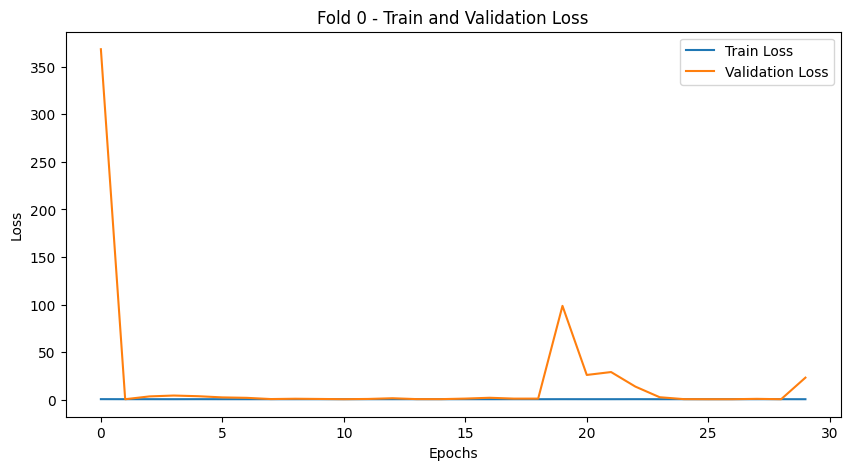

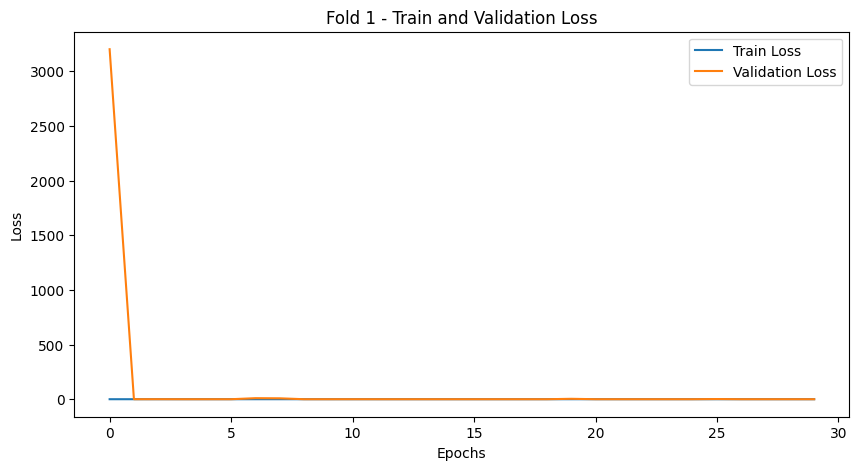

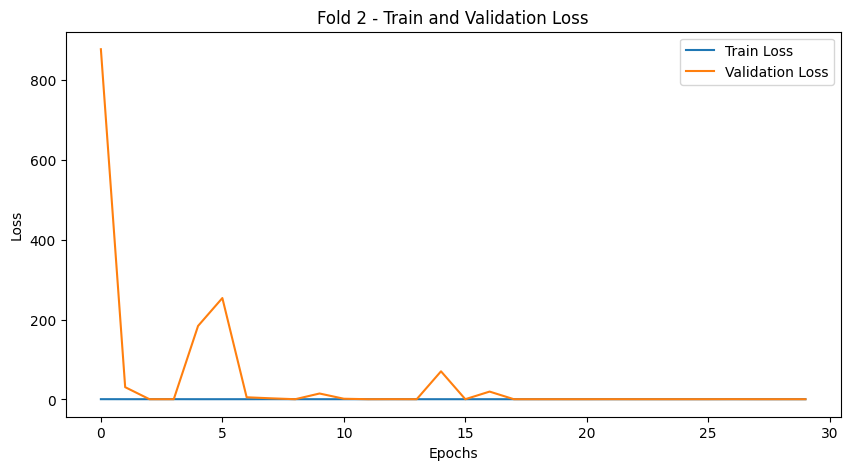

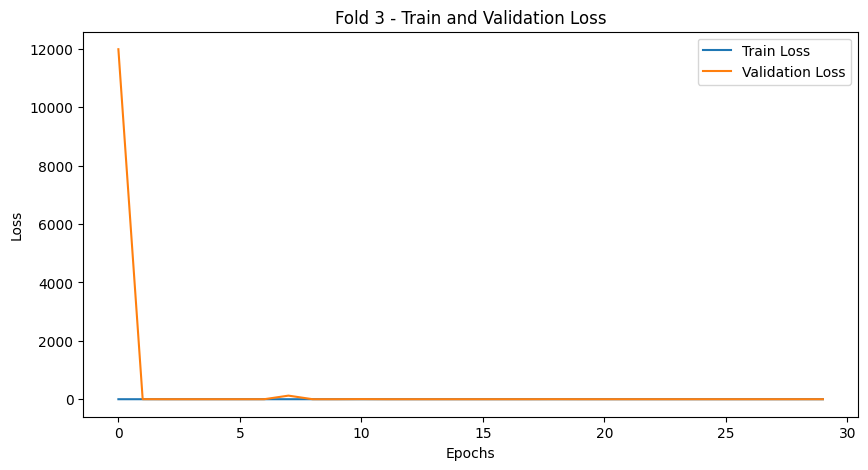

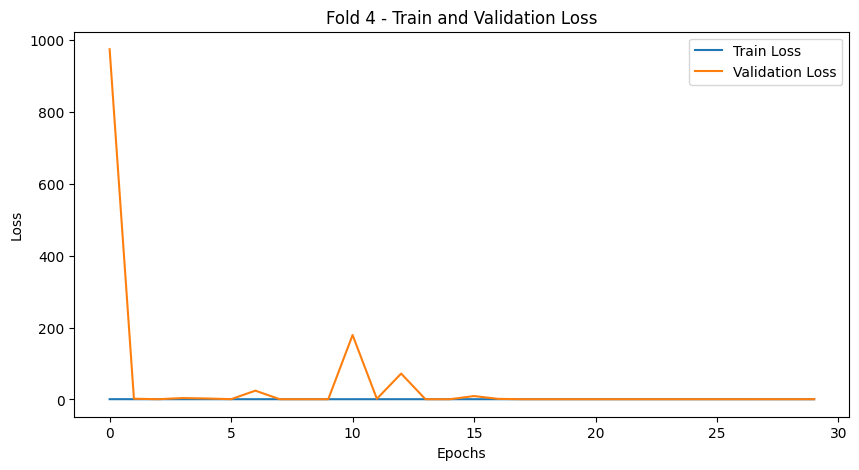

In [29]:
## Criar graficos de treinamento e validacao
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss_total[i], label='Train Loss')
    plt.plot(val_loss_total[i], label='Validation Loss')
    plt.title(f'Fold {i} - Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'output/graficos/loss_fold_{i}.png')
    plt.show()
    plt.close()
